In [2]:
from utils.data_loading import load_dataset
train_data, val_data, test_data, full_training_data = load_dataset("datasets/it-trajs/", diff=False, scaler=None)

In [3]:
# for all: mean, median, std, max, min
"""
The statistical summary consisted of
the mean, median, standard deviation, 1st quartile, 3rd quartile, kurtosis (a measure of the
tailedness of a distribution), skewness (a measure of the asymmetry of a distribution), the
number of local minima and maxima, and the number of zero crossings.
"""
# Velocity, Acceleration, and Jerk
# Angle of Flight
# Angular Velocity and Angular Acceleration
# Straightness
# Curvature

'\nThe statistical summary consisted of\nthe mean, median, standard deviation, 1st quartile, 3rd quartile, kurtosis (a measure of the\ntailedness of a distribution), skewness (a measure of the asymmetry of a distribution), the\nnumber of local minima and maxima, and the number of zero crossings.\n'

In [4]:
import numpy as np
import pandas as pd

def compute_velocity(df):
    """
    Compute instantaneous speed (velocity magnitude) assuming unit time intervals.
    Velocity at step i = distance between point i and i+1.
    """
    dx = np.diff(df['x'].values)
    dy = np.diff(df['y'].values)
    speed = np.sqrt(dx**2 + dy**2)
    return speed

def compute_acceleration(velocity):
    """
    Compute acceleration as discrete time derivative of speed.
    Acceleration at step i = velocity[i+1] - velocity[i].
    """
    return np.diff(velocity)

def compute_jerk(acceleration):
    """
    Compute jerk as discrete time derivative of acceleration.
    Jerk at step i = acceleration[i+1] - acceleration[i].
    """
    return np.diff(acceleration)

def compute_angle(df):
    """
    Compute heading angle of movement vectors.
    Angle at step i = arctan2(dy, dx) between consecutive points.
    Unwrap to avoid discontinuities at ±π.
    """
    dx = np.diff(df['x'].values)
    dy = np.diff(df['y'].values)
    angle = np.arctan2(dy, dx)
    return np.unwrap(angle)

def compute_angular_velocity(angle):
    """
    Compute angular velocity as discrete time derivative of heading angle.
    """
    return np.diff(angle)

def compute_angular_acceleration(angular_velocity):
    """
    Compute angular acceleration as discrete time derivative of angular velocity.
    """
    return np.diff(angular_velocity)

def compute_straightness(df):
    """
    Compute local straightness over sliding windows of 3 points.
    """
    x, y = df['x'].values, df['y'].values
    n = len(x)
    s = []
    for i in range(n - 2):
        p0, p1, p2 = np.array([x[i], y[i]]), np.array([x[i+1], y[i+1]]), np.array([x[i+2], y[i+2]])
        disp = np.linalg.norm(p2 - p0)
        path = np.linalg.norm(p1 - p0) + np.linalg.norm(p2 - p1)
        s.append(disp / path if path != 0 else np.nan)
    return np.array(s)


def compute_curvature(df, eps=1e-8):
    """
    Estimate curvature at each point using discrete derivatives:
      k = |x' y'' - y' x''| / (x'^2 + y'^2)^(3/2)
    
    To avoid division by zero, we:
      1) compute denom = (dx^2 + dy^2)**1.5
      2) replace any denom < eps with eps
      3) compute k safely
      4) set curvature to 0 where the movement is truly stationary
    """
    x = df['x'].values
    y = df['y'].values

    # first derivatives
    dx = np.gradient(x)
    dy = np.gradient(y)
    # second derivatives
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)

    # numerator of curvature formula
    num = np.abs(dx * ddy - dy * ddx)
    # denominator, with small epsilon floor
    denom = (dx**2 + dy**2)**1.5
    denom = np.where(denom < eps, eps, denom)

    k = num / denom

    return k

def compute_stillness(df):
    """
    Count timesteps where the insect is still:
    Positions where both x and y do not change from previous frame.
    """
    dx = np.diff(df['x'].values)
    dy = np.diff(df['y'].values)
    # Still when no movement in both axes
    return int(np.sum((dx == 0) & (dy == 0)))

import numpy as np
from scipy.spatial import ConvexHull

def compute_step_length_stats(df):
    """
    Compute statistics of the step-length distribution (distances between successive points).
    Returns a dict with:
      - mean: average step length
      - variance: variance of step lengths
      - skewness: measure of asymmetry of the distribution
      - kurtosis: excess kurtosis (peakedness relative to normal)
    """
    dx = np.diff(df['x'].values)
    dy = np.diff(df['y'].values)
    steps = np.sqrt(dx**2 + dy**2)
    μ = np.mean(steps)
    σ = np.std(steps)
    skew = np.mean((steps - μ)**3) / σ**3 if σ > 0 else np.nan
    kurt = np.mean((steps - μ)**4) / σ**4 - 3 if σ > 0 else np.nan
    return {
        'step_mean': μ,
        'step_variance': σ**2,
        'step_skewness': skew,
        'step_kurtosis': kurt
    }

def compute_turning_angle_stats(df):
    """
    Compute turning-angle features:
      - mean_resultant_length: directional persistence
      - var, skewness, kurtosis of the turn-angle distribution
    Angles are wrapped to [-π, π].
    """
    dx = np.diff(df['x'].values)
    dy = np.diff(df['y'].values)
    angles = np.arctan2(dy, dx)
    turns = np.diff(angles)
    # wrap turns into [-π,π]
    turns = (turns + np.pi) % (2 * np.pi) - np.pi
    
    n = len(turns)
    cr = np.sum(np.cos(turns)) / n
    sr = np.sum(np.sin(turns)) / n
    mean_res_len = np.sqrt(cr**2 + sr**2)
    
    μ = np.mean(turns)
    σ = np.std(turns)
    skew = np.mean((turns - μ)**3) / σ**3 if σ > 0 else np.nan
    kurt = np.mean((turns - μ)**4) / σ**4 - 3 if σ > 0 else np.nan
    
    return {
        'turn_mrl': mean_res_len,
        'turn_variance': σ**2,
        'turn_skewness': skew,
        'turn_kurtosis': kurt
    }

def compute_pause_bout_stats(df, speed_thresh=1e-3):
    """
    Detect pause bouts where instantaneous speed < speed_thresh.
    Returns:
      - n_pauses: number of pause bouts
      - mean_pause_duration: average frames per pause
      - median_pause_duration
      - fraction_paused: total paused frames / total steps
      - pause_to_move_rate: transitions from pause to move per frame
      - move_to_pause_rate: transitions from move to pause per frame
    """
    dx = np.diff(df['x'].values)
    dy = np.diff(df['y'].values)
    speed = np.sqrt(dx**2 + dy**2)
    paused = speed < speed_thresh
    
    # find transitions
    trans = np.diff(paused.astype(int))
    starts = np.where(trans == 1)[0] + 1  # move→pause
    ends   = np.where(trans == -1)[0] + 1 # pause→move
    
    # handle edge cases if track starts or ends paused
    if paused[0]:
        starts = np.insert(starts, 0, 0)
    if paused[-1]:
        ends = np.append(ends, len(paused))
    
    durations = ends - starts
    n_pauses = len(durations)
    
    return {
        'n_pauses': n_pauses,
        'mean_pause_dur': np.mean(durations) if n_pauses > 0 else 0,
        'median_pause_dur': np.median(durations) if n_pauses > 0 else 0,
        'fraction_paused': np.sum(paused) / len(paused),
        'pause_to_move_rate': len(ends) / len(paused),
        'move_to_pause_rate': len(starts) / len(paused)
    }

def compute_convex_hull_area(df):
    """
    Compute the area of the convex hull enclosing the track points.
    Uses scipy.spatial.ConvexHull; in 2D its 'volume' attribute is the area.
    """
    pts = np.vstack([df['x'].values, df['y'].values]).T
    if len(pts) < 3:
        return 0.0
    hull = ConvexHull(pts)
    return hull.volume

def compute_radius_of_gyration(df):
    """
    Compute the radius of gyration:
    sqrt(mean((x - x_mean)^2 + (y - y_mean)^2))
    Measures how tightly the path clusters around its centroid.
    """
    x = df['x'].values
    y = df['y'].values
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    return np.sqrt(np.mean((x - x_mean)**2 + (y - y_mean)**2))



import numpy as np
import pandas as pd

# Assuming you already have these compute_* functions defined/imported:
# compute_velocity, compute_acceleration, compute_jerk,
# compute_angle, compute_angular_velocity, compute_angular_acceleration,
# compute_straightness, compute_curvature, compute_stillness,
# compute_step_length_stats, compute_turning_angle_stats,
# compute_pause_bout_stats, compute_convex_hull_area,
# compute_radius_of_gyration

def extract_features(df):
    """
    Compute summary statistics of kinematic and geometric features:
    - velocity, acceleration, jerk
    - angle, angular velocity, angular acceleration
    - straightness, curvature
    - stillness count
    - step-length distribution stats
    - turning-angle distribution stats
    - pause-bout metrics
    - convex-hull area
    - radius of gyration
    
    Returns a pandas Series with all features.
    """
    # 1) Raw kinematic/geometric arrays
    vel    = compute_velocity(df)
    acc    = compute_acceleration(vel)
    jerk   = compute_jerk(acc)
    angle  = compute_angle(df)
    ang_vel = compute_angular_velocity(angle)
    ang_acc = compute_angular_acceleration(ang_vel)
    straight = compute_straightness(df)
    curvature = compute_curvature(df)
    still_cnt = compute_stillness(df)
    
    # 2) Summarize arrays (mean, median, min, max, std, min_nonzero)
    def summarize(arr, name):
        arr_clean = arr[~np.isnan(arr)]
        nonzero = arr_clean[arr_clean != 0]
        return {
            f"{name}_mean":        np.nanmean(arr_clean),
            f"{name}_median":      np.nanmedian(arr_clean),
            f"{name}_min":         np.nanmin(arr_clean),
            f"{name}_max":         np.nanmax(arr_clean),
            f"{name}_std":         np.nanstd(arr_clean),
            f"{name}_min_nonzero": (np.nanmin(nonzero) if nonzero.size > 0 else np.nan)
        }
    
    features = {}
    for arr, name in [
        (vel, "velocity"), (acc, "acceleration"), (jerk, "jerk"),
        (angle, "angle"), (ang_vel, "angular_velocity"),
        (ang_acc, "angular_acceleration"),
        (straight, "straightness"), (curvature, "curvature")
    ]:
        features.update(summarize(arr, name))
    
    # 3) Add scalar features
    features["stillness_count"] = still_cnt
    
    # 4) Add new feature groups (dicts)
    features.update(compute_step_length_stats(df))
    features.update(compute_turning_angle_stats(df))
    features.update(compute_pause_bout_stats(df))
    
    # 5) Add single-value spatial features
    features["convex_hull_area"]      = compute_convex_hull_area(df)
    features["radius_of_gyration"]    = compute_radius_of_gyration(df)
    
    return pd.Series(features)




In [5]:
train_dict = train_data.tracks_dict
# for item in train_dict.values():
#     print(item)
#     break
df = train_dict['1_057.csv']['dataframe']

In [6]:
features = extract_features(df)
print(features)

velocity_mean         0.006128
velocity_median       0.001816
velocity_min          0.000000
velocity_max          0.049539
velocity_std          0.009961
                        ...   
fraction_paused       0.286127
pause_to_move_rate    0.141618
move_to_pause_rate    0.141618
convex_hull_area      0.231868
radius_of_gyration    0.288516
Length: 65, dtype: float64


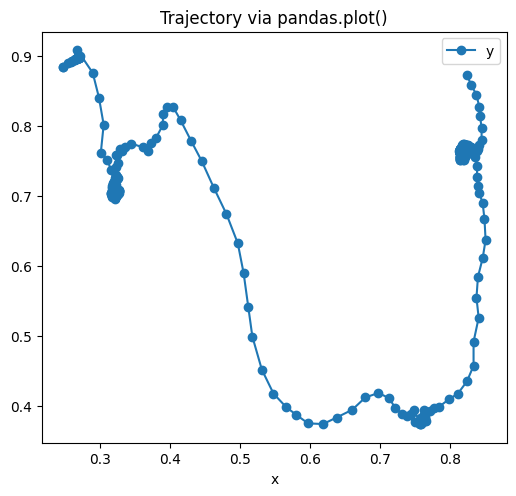

In [7]:
import matplotlib.pyplot as plt
## trajectory
ax = df.plot(kind='line', x='x', y='y', figsize=(6,6), marker='o')
ax.set_aspect('equal', 'box')
ax.set_title('Trajectory via pandas.plot()')
plt.show()

In [8]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report

# 1) load your data
from utils.data_loading import load_dataset
train_data, val_data, test_data, full_training_data = load_dataset(
    "datasets/it-trajs/", diff=False, scaler=None
)

def build_X_y(dataset):
    feats, labels = [], []
    for fname, track in dataset.tracks_dict.items():
        feats.append(extract_features(track['dataframe']))
        labels.append(int(track['label']))      # ensure labels are integers
    X = pd.DataFrame(feats)
    y = pd.Series(labels, name='label', dtype=int)
    return X, y

# 2) build feature matrices
X_train, y_train = build_X_y(full_training_data)
X_test,  y_test  = build_X_y(test_data)

# 3) define a set of candidate models
models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=500, random_state=42, n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    ),
    'SVM': SVC(
        kernel='rbf', probability=True, random_state=42
    ),
    'DecisionTree': DecisionTreeClassifier(
        random_state=42
    ),
    'KNN': KNeighborsClassifier(
        n_neighbors=5, n_jobs=-1
    )
}

# 4) cross-validate each model on the full training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

cv_summary = {}
for name, clf in models.items():
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler',  StandardScaler()),
        ('clf',     clf)
    ])
    scores = cross_validate(
        pipe,
        X_train, y_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )
    cv_summary[name] = {
        metric: (np.mean(scores[f'test_{metric}']),
                 np.std(scores[f'test_{metric}']))
        for metric in scoring
    }

cv_df = pd.DataFrame(cv_summary).T
print("=== Cross‐Validation Results (mean ± std) ===")
print(cv_df)

# 5) finally, train each on the full training set and evaluate on the test set
for name, clf in models.items():
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler',  StandardScaler()),
        ('clf',     clf)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(f"\n=== {name} Test‐Set Performance ===")
    print(classification_report(y_test, y_pred))


=== Cross‐Validation Results (mean ± std) ===
                                                accuracy  \
RandomForest  (0.6853061224489796, 0.059031189914800004)   
XGBoost        (0.6692244897959184, 0.05814434350289595)   
SVM             (0.685469387755102, 0.04535103491851013)   
DecisionTree  (0.5644081632653062, 0.013146152457968324)   
KNN            (0.6488163265306123, 0.05422436306084596)   

                                         precision_macro  \
RandomForest   (0.6788128538128537, 0.06701220490483452)   
XGBoost       (0.6598421676362853, 0.062146140187631156)   
SVM            (0.6785447266871415, 0.04871466812074453)   
DecisionTree  (0.5701269604578428, 0.016712752561519936)   
KNN           (0.6442020683564801, 0.054380054093506165)   

                                            recall_macro  \
RandomForest   (0.6865384615384615, 0.05814106097870186)   
XGBoost         (0.671474358974359, 0.05682214139571136)   
SVM            (0.6865384615384615, 0.04389504696351

Top 10 features by RF impurity‐based importance:
n_pauses                0.067035
angle_std               0.047192
stillness_count         0.043383
convex_hull_area        0.037354
radius_of_gyration      0.036012
move_to_pause_rate      0.028765
angular_velocity_std    0.028570
pause_to_move_rate      0.027664
straightness_std        0.027082
velocity_median         0.026044
dtype: float64


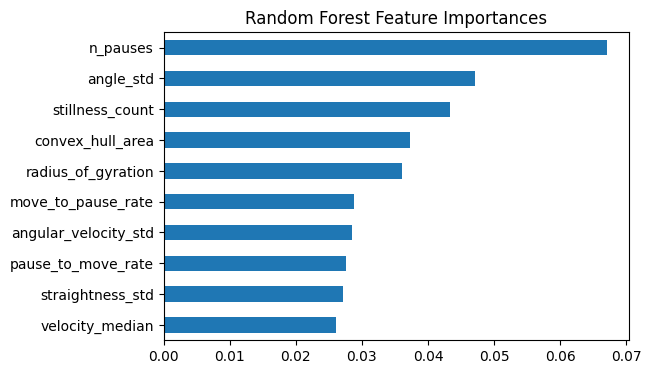

Top 10 features by permutation importance (on test set):
velocity_min_nonzero     0.016431
curvature_median         0.016048
acceleration_std         0.013837
jerk_std                 0.008648
move_to_pause_rate       0.007783
radius_of_gyration       0.007198
velocity_max             0.006054
stillness_count          0.004991
turn_kurtosis            0.004324
angular_velocity_mean    0.002594
dtype: float64


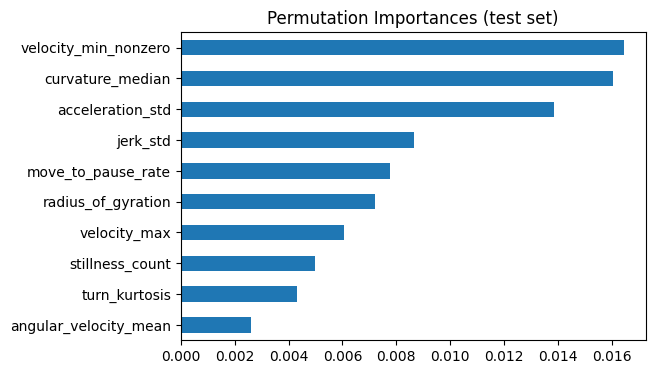

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.inspection import permutation_importance

# 1) Fit your RandomForest pipeline on the full training data
rf_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler()),
    ('clf',     RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1))
])
rf_pipe.fit(X_train, y_train)

# 2) Extract the fitted RF and feature names
rf = rf_pipe.named_steps['clf']
feature_names = X_train.columns

# 3a) Tree-based importances
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=feature_names)
feat_imp = feat_imp.sort_values(ascending=False)

print("Top 10 features by RF impurity‐based importance:")
print(feat_imp.head(10))

# (Optional) bar-plot
plt.figure(figsize=(6,4))
feat_imp.head(10).plot.barh()
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importances")
plt.show()

from sklearn.inspection import permutation_importance

# 1) Fit on training set (as before)
rf_pipe.fit(X_train, y_train)

# 2) Compute permutation importances on the *test* set
perm_imp = permutation_importance(
    rf_pipe, 
    X_test,                   # <— use held-out data, not X_train
    y_test, 
    n_repeats=20,             # more repeats → smoother estimates
    random_state=42,
    n_jobs=-1,
    scoring='f1_macro'        # pick the metric you care about
)

# 3) Turn into a sorted Series
perm_series = pd.Series(
    perm_imp.importances_mean, 
    index=X_train.columns
).sort_values(ascending=False)

# 4) Inspect top features
print("Top 10 features by permutation importance (on test set):")
print(perm_series.head(10))

# 5) Plot them
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
perm_series.head(10).plot.barh()
plt.gca().invert_yaxis()
plt.title("Permutation Importances (test set)")
plt.show()
